In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

X_VER = 186

USE = 'orders'

In [2]:
import pandas as pd, cudf, numpy as np, gc
import matplotlib.pyplot as plt

In [ ]:
users = pd.read_parquet(f'../../data/train_with_features/train_v172.pqt')

In [ ]:
# SWAP WGT AND SCORE_30
tmp = users.wgt.values.copy()
users['wgt'] = users['score_30'].values
users['score_30'] = tmp
del tmp

# XGBoost

In [5]:
FEATURES = ['pos', 'wgt', 'score_1', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_10', 'score_11',
            'score_12', 'score_13', 'score_30', 'score_14', 'score_15', 'score_16', 'score_17', 'score_18', 
            'score_19', 'score_20', 'score_21', 'score_22', 'score_23', 'score_24', 'score_25', 'score_26', 
            'buy_ratio_5', 'count_item_5', 'count_user_5', 'repeat_5', 'buy_ratio_std_5', 'item_day_std_5', 
            'user_day_std_5', 'buy_ratio_0_6', 'buy_ratio_1_6', 'buy_ratio_2_6', 'buy_ratio_3_6', 'buy_ratio_4_6',
            'buy_ratio_5_6', 'buy_ratio_6_6', 'count_item_0_6', 'count_item_1_6', 'count_item_2_6', 'count_item_3_6',
            'count_item_4_6', 'count_item_5_6', 'count_item_6_6', 'count_user_0_6', 'count_user_1_6', 
            'count_user_2_6', 'count_user_3_6', 'count_user_4_6', 'count_user_5_6', 'count_user_6_6', 
            'item_day_std_6', 'user_day_std_6', 'buy_ratio', 'count_item', 'count_user', 'hour_mean', 
            'day_mean', 'repeat', 'buy_ratio_std', 'hour_std', 'day_std', 'buy_ratio3', 'count_item3', 
            'count_user3', 'hour_mean3', 'day_mean3', 'repeat3', 'buy_ratio_std3', 'hour_std3', 'day_std3', 
            'prev3', 'next3', 'orders3', 'carts3', 'order_repeat3', 'cart_repeat3', 'buy_ratio2', 'count_item2', 
            'unique_item2', 'hour_mean2', 'day_mean2', 'repeat2', 'buy_ratio_std2', 'hour_std2', 'day_std2',
            'ts_max7', 'ts_min7', 'ts_diff7', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'buy_ratio7', 'count_item7',
            'count_user7', 'hour_mean7', 'day_mean7', 'repeat7', 'buy_ratio_std7', 'hour_std7', 'day_std7',
            'prev7', 'next7', 'orders7', 'carts7', 'order_repeat7', 'cart_repeat7', 'buy_ratio8', 'count_item8', 
            'count_user8', 'hour_mean8', 'day_mean8', 'repeat8', 'buy_ratio_std8', 'hour_std8', 'day_std8', 
            'prev8', 'next8', 'orders8', 'carts8', 'order_repeat8', 'cart_repeat8', 'buy_ratio9', 'count_item9', 
            'count_user9', 'hour_mean9', 'day_mean9', 'repeat9', 'buy_ratio_std9', 'hour_std9', 'day_std9', 
            'prev9', 'next9', 'orders9', 'carts9', 'order_repeat9', 'cart_repeat9', 'buy_ratio10', 'count_item10',
            'unique_item10', 'hour_mean10', 'day_mean10', 'repeat10', 'buy_ratio_std10', 'hour_std10', 'day_std10']
len(FEATURES)

152

In [6]:
users = users[['user','item']+FEATURES]
print( users.shape )
users.head()

(13465600, 154)


,user,item,pos,wgt,score_1,score_3,score_4,score_5,score_6,score_7,...,cart_repeat9,buy_ratio10,count_item10,unique_item10,hour_mean10,day_mean10,repeat10,buy_ratio_std10,hour_std10,day_std10
0,11098528,11830,0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.965084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11098528,1732105,1,10.995,2.0,2.0,-3.0,2.0,3.5,4.0,...,1.952507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11098528,588923,2,14.500,2.0,1.0,-3.0,2.0,4.0,2.0,...,2.031830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11098528,1157882,3,11.980,1.0,1.0,-3.0,1.0,2.0,2.0,...,1.897436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11098528,884502,4,12.485,1.0,1.0,-3.0,1.0,2.0,2.0,...,1.925403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# LOAD XGB LIBRARY
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
print('XGB Version',xgb.__version__)

FOLDS = 5
SEED = 42

LR = 0.1

# XGB MODEL PARAMETERS
xgb_parms = { 
    'max_depth':4, 
    'learning_rate':LR, 
    'subsample':0.7,
    'colsample_bytree':0.5, 
    #'eval_metric':'rmse',
    'objective':'rank:pairwise',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

XGB Version 1.5.2


In [8]:
from sklearn.model_selection import GroupKFold

In [9]:
users['click_oof'] = 0

In [10]:
%%time
for fold in range(FOLDS):
    print('#'*25)
    print('### Fold',fold+1)
    print('#'*25)
    
    print(f'=> predicting XGB {X_VER}...')
    model = xgb.Booster()
    model.load_model(f'../../data/item_user_features/models/XGB_fold{fold}_{USE}_v{X_VER}.xgb')
    model.set_param({'predictor': 'gpu_predictor'})
    model.set_param({'gpu_id': 0})
    
    USR = np.load( f'../../data/models/valid_users_{X_VER}_f{fold}.npy' )
    print( 'user count',len(USR) )
    mask = users.user.isin(USR)
    
    # INFER OOF FOLD K
    X_valid = users.loc[mask,FEATURES]
    dvalid = xgb.DMatrix(data=X_valid) 
    oof_preds = model.predict(dvalid)
    users.loc[mask,'click_oof'] = oof_preds
    
    del dvalid, X_valid, model 
    gc.collect()

#########################
### Fold 1
#########################
=> predicting XGB 186...
user count 360250
#########################
### Fold 2
#########################
=> predicting XGB 186...
user count 360250
#########################
### Fold 3
#########################
=> predicting XGB 186...
user count 360250
#########################
### Fold 4
#########################
=> predicting XGB 186...
user count 360250
#########################
### Fold 5
#########################
=> predicting XGB 186...
user count 360251
CPU times: user 3min 44s, sys: 21.6 s, total: 4min 6s
Wall time: 1min 14s


In [16]:
coof = users.click_oof.values
#np.save(f'/raid/Kaggle/otto/data16/click_oof{X_VER}_{USE}', coof)

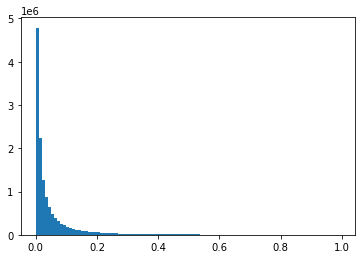

In [13]:
plt.hist(coof,bins=100)
plt.show()

In [14]:
%%time
users = pd.read_parquet(f'../../data/train_with_features/train_v172.pqt')
users['click_oof'] = coof
users['click_oof'] = users['click_oof'].astype('float32')
users.to_parquet(f'../../data/train_with_features/train_v172_X.pqt', index=False)

CPU times: user 2min 20s, sys: 23.6 s, total: 2min 43s
Wall time: 1min 10s
